## 1. Выбор и описание датасета

На данном этапе производится загрузка датасета и его описание, а также постановка решаемой задачи.

Для выполнения работы был выбран датасет RuSentiment — это корпус сообщений из социальной сети «ВКонтакте», размеченных вручную по эмоциональной тональности. Датасет широко используется для обучения и оценки моделей в задачах анализa тональности текста на русском языке.
Изначально датасет включает следующие метки:

- `positive` — положительная оценка или настроение;
- `neutral` — нейтральное сообщение;
- `negative` — негативная оценка или настроение;
- `speech` — речевые акты (поздравления, благодарности);
- `skip` — пропущенные, неанализируемые или неуместные сообщения.

В данной работе используются только три основные метки, поскольку они соответствуют постановке задачи классификации по эмоциональной окраске текста. Задача — разработать и сравнить модели машинного обучения для многоклассовой классификации сообщений по тональности. 
Используемые метки:

- `positive`,
- `neutral`,
- `negative`.

In [5]:
import pandas as pd

# Загрузка датасета
df = pd.read_csv('data/rusentiment_random_posts.csv')

# Предварительный просмотр
df.head(10)

,label,text
0,negative,"А попа подозревала давно,что ты с кавказа..пер..."
1,speech,З прошедшим Днем Ангела))))))))
2,skip,Два дня до отлёта с острова!!!!!!!
3,negative,"Блин, почему эта жизнь столь не справедлива (((("
4,skip,где еще встречать свой день рождения как не на...
5,neutral,Решите уравнение мужских дел для жизни :\r\nДо...
6,positive,патамушта я крутая баба! ееее!!
7,neutral,Просто пост :)
8,positive,урря!я дождался этой овцыы)
9,speech,"С Днем Рождения желаю много счастья, любви и у..."


# 2. Предварительный анализ и очистка данных

Проверка датасета на наличие пропущенных значений и дублирующихся записей, а также отбор целевых меток. Из анализа исключаются сообщения, не содержащие текст или размеченные как нерелевантные (`speech`, `skip`).

Также оценивается распределение классов.

### 2.1 Количественные характеристики и структура данных

In [6]:
# Количественные характеристики
print("Общее количество записей:", len(df))
print("Число уникальных классов:", df['label'].nunique())
print("\nРаспределение классов:")
print(df['label'].value_counts())

Общее количество записей: 21268
Число уникальных классов: 5

Распределение классов:
label
neutral     8323
positive    4635
skip        3190
speech      2826
negative    2294
Name: count, dtype: int64


`text` — входной признак, `label` — целевая переменная для обучения модели.

### 2.2 Проверка и очистка данных

In [7]:
# Удаление нерелевантных меток
df = df[df['label'].isin(['positive', 'neutral', 'negative'])]

# Проверка пропущенных значений и дубликатов
print("Пропущенные значения:", df['text'].isnull().sum())
print("Дубликатов:", df.duplicated().sum())

# Удаление пропусков и дубликатов
df.dropna(subset=['text'], inplace=True)
df.drop_duplicates(inplace=True)

print("Размерность после очистки:", df.shape)

Пропущенные значения: 0
Дубликатов: 35
Размерность после очистки: (15217, 2)


### 2.3 Анализ распределения классов

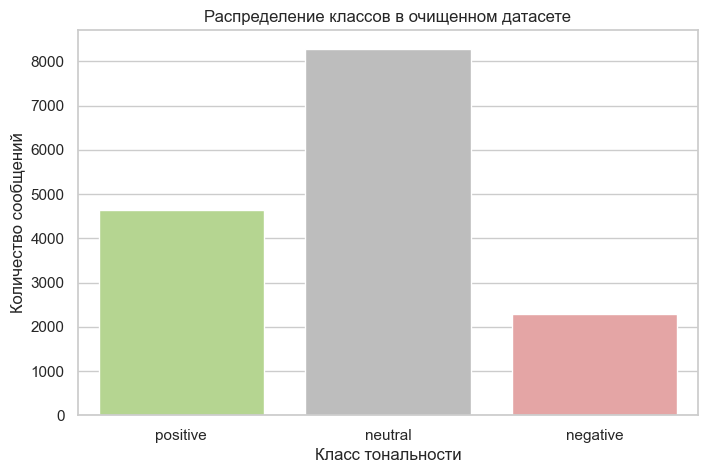

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
custom_palette = {
    'positive': "#B6E086", 
    'neutral':  '#BDBDBD', 
    'negative': '#EF9A9A' 
}

# Построение диаграммы распределения
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x='label',
    hue='label',
    order=['positive', 'neutral', 'negative'],
    palette=custom_palette,
    legend=False
)
plt.title('Распределение классов в очищенном датасете')
plt.xlabel('Класс тональности')
plt.ylabel('Количество сообщений')
plt.show()

In [9]:
# Вывод процентного распреления классов
class_counts = df['label'].value_counts()
class_percentages = df['label'].value_counts(normalize=True) * 100

class_distribution = pd.DataFrame({
    'Количество': class_counts,
    'Доля (%)': class_percentages.round(2)
})

print("Распределение классов:")
display(class_distribution)

Распределение классов:


,Количество,Доля (%)
label,,
neutral,8291,54.49
positive,4632,30.44
negative,2294,15.08


В результате анализа установлено, что нейтральные сообщения составляют наибольшую долю в выборке. Это может потребовать применения методов балансировки данных на последующих этапах.

### 2.4 Кодирование целевой переменной

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Сопоставление меток:")
for label, code in label_map.items():
    print(f"{label} → {code}")

Сопоставление меток:
negative → 0
neutral → 1
positive → 2


### 2.5 Примеры данных

In [11]:
for label in ['positive', 'neutral', 'negative']:
    print(f"\nПримеры {label.upper()}:")
    samples = df[df['label'] == label]['text'].dropna().sample(3)
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}")


Примеры POSITIVE:
1. ааааааааааа ваще ностальгия
2. Анюта,день был на ура..))
3. во блин тоже хочу фото с гордоном фриманом! это же HL

Примеры NEUTRAL:
1. мне важно знать, что я для тебя значу.
2. Ура! Золото дают бесплатно!Напиши это в 4 комментариях и иди к Саше или Маше f5 выбери сколько надо 
И это правдо?
3. О падении курса рубля: Если я правильно понял - наши "запасы" в " долговых обязательствах " и в " долларах ". Запасы Казахстана приблизительно такие же. Вопрос : Почему не продать доллары и не потребовать деньги обратно по долговым обязательствам (до определенного уровня)? Это должно "вернуть" курс обратно и, более того, дать прибыль. В чем я не прав?﻿

Примеры NEGATIVE:
1. Очередная бесполезная вещь, которую я зачем то сделал.
2. чего-то как-то толком не работает оно
3. мы так её и не спели:(


# 3. Преобразование признаков (векторизация текста)

На данном этапе выполняется предобработка и  последующая векторизация текстов с помощью TF-IDF (Term Frequency–Inverse Document Frequency), которая отражает важность слов относительно каждого документа и всей выборки в целом.

TF-IDF позволяет учитывать как частотность слова в конкретном сообщении, так и его редкость по корпусу, что делает модель более устойчивой к часто встречающимся словам и выделяет информативные признаки.


### 3.1 Предобработка текста

Исходные сообщения содержат пунктуацию, смайлики, хештеги и символы, не несущие полезной смысловой нагрузки. Для повышения качества признаков производится очистка текста:
- приведение к нижнему регистру;
- удаление пунктуации и неалфавитных символов;
- лемматизация слов с использованием библиотеки `pymorphy3`;
- удаление стоп-слов (по списку NLTK).


In [12]:
import re
import pymorphy3
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk_data_path = "data/nltk"
nltk.data.path.append(nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)

morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words("russian"))
punctuation = r"[^\w\s]"

[nltk_data] Downloading package punkt to data/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to data/nltk...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to data/nltk...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление пунктуации и лишних символов
    text = re.sub(punctuation, ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Токенизация
    tokens = word_tokenize(text)

    # Лемматизация + фильтрация стоп-слов
    lemmas = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if token not in stop_words and token.isalpha()
    ]

    return ' '.join(lemmas)


In [14]:
df['text_preprocessed'] = df['text'].apply(preprocess_text)
df[['text', 'text_preprocessed']].head(10)

,text,text_preprocessed
0,"А попа подозревала давно,что ты с кавказа..пер...",поп подозревать давно кавказ перестать общатьс...
3,"Блин, почему эта жизнь столь не справедлива ((((",блин почему этот жизнь столь справедливый
5,Решите уравнение мужских дел для жизни :\r\nДо...,решить уравнение мужской дело жизнь дом дерево...
6,патамушта я крутая баба! ееее!!,патамушт крутой баба ееий
7,Просто пост :),просто пост
8,урря!я дождался этой овцыы),уррить дождаться овцы
11,Наша гордость !,наш гордость
13,"Походу, первым кто поздравил меня с 1 апреля -...",поход первый поздравить апрель это ржд мина жд...
14,познакомил свою девушку с Ксюшей,познакомить девушка ксюша
18,Тесака арестовали...,тесак арестовать


### 3.2 Векторизация TF-IDF

Для векторизации текстов используется схема TF-IDF с диапазоном `ngram_range=(1, 2)` для учёта как отдельных слов (униграмм), так и устойчивых словосочетаний (биграмм), что особенно актуально в задачах анализа тональности.
Ограничение `max_features=10000` введено с целью исключения редких и нерелевантных слов, а также для уменьшения размерности признакового пространства и повышения устойчивости модели.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

russian_stopwords = stopwords.words("russian")

# Векторизация текста
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),     # униграммы и биграммы
    max_features=10000,     # ограничение на размер словаря
    stop_words=russian_stopwords
)

X = vectorizer.fit_transform(df['text'])
y = df['label_encoded']

print(f"Размерность матрицы признаков: {X.shape}")

Размерность матрицы признаков: (15217, 10000)


В данном пункте была продемонстрирована реализация векторизации текста вручную с использованием TF-IDF, как отдельного этапа обработки. Однако при построении полного процесса обучения моделей в рамках сравнения алгоритмов, используется программный конвейер (`Pipeline`) из библиотеки `scikit-learn`, объединяющий этапы преобразования текста и обучения классификатора.

# 4. Описательный анализ признаков

Поскольку в данной задаче все входные признаки являются результатом векторизации текста методом TF-IDF, они имеют интервальную шкалу измерения и представляют собой числовые значения в диапазоне от 0 до 1. Каждый признак соответствует частотной характеристике отдельного слова или сочетания слов в тексте, и не обладает фиксированной смысловой интерпретацией.

Полноценный описательный анализ, включая проверку нормальности, корреляционный анализ и визуализацию каждого признака, не представляется целесообразным в данной постановке задачи. Это связано с высокой размерностью признакового пространства (10 000 признаков) и тем, что признаки не обладают явным физическим смыслом или шкалой.

В качестве вспомогательного анализа проведено изучение распределения длины сообщений по числу символов и слов, так как это может опосредованно влиять на характер векторных представлений.


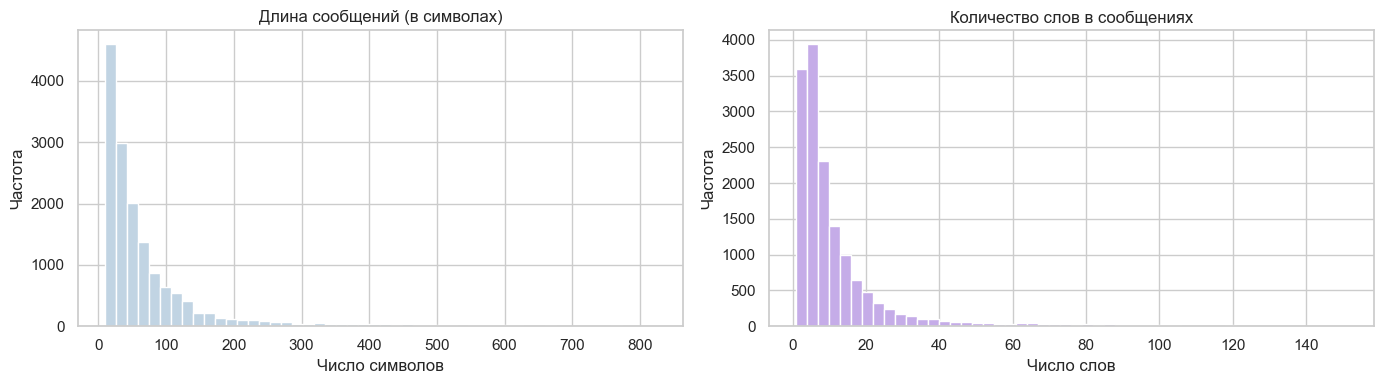

In [16]:
# Расчёт длины сообщений
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Распределение по числу символов
axes[0].hist(df['text_length'], bins=50, color="#C1D4E3")
axes[0].set_title("Длина сообщений (в символах)")
axes[0].set_xlabel("Число символов")
axes[0].set_ylabel("Частота")

# Распределение по числу слов
axes[1].hist(df['word_count'], bins=50, color='#C5ACE8')
axes[1].set_title("Количество слов в сообщениях")
axes[1].set_xlabel("Число слов")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()


Большинство сообщений содержат от 5 до 20 слов и менее 150 символов. Это подтверждает, что сообщения короткие, что типично для пользовательского контента в социальных сетях. Данный анализ дополнительно обосновывает выбор параметров TF-IDF и ограничение словаря до 10 000 признаков.

# 5. Методы обучения без учителя

Данный пункт не реализован в рамках работы, поскольку исследуемая задача предполагает наличие размеченной выборки и решается методами обучения с учителем. Все сообщения снабжены метками эмоциональной тональности, и основной целью является построение и сравнение моделей классификации. 

# 6. Разделение выборки на обучающую и тестовую

В рамках данной работы используется случайное разбиение выборки на обучающую и тестовую части. Размер тестовой выборки составляет 20%.

Для сохранения пропорций классов в обеих выборках используется стратифицированное разбиение (Stratified Split), что позволяет предотвратить смещение модели в сторону доминирующего класса.


In [17]:
df.head(10)

,label,text,label_encoded,text_preprocessed,text_length,word_count
0,negative,"А попа подозревала давно,что ты с кавказа..пер...",0,поп подозревать давно кавказ перестать общатьс...,69,10
3,negative,"Блин, почему эта жизнь столь не справедлива ((((",0,блин почему этот жизнь столь справедливый,48,8
5,neutral,Решите уравнение мужских дел для жизни :\r\nДо...,1,решить уравнение мужской дело жизнь дом дерево...,79,16
6,positive,патамушта я крутая баба! ееее!!,2,патамушт крутой баба ееий,31,5
7,neutral,Просто пост :),1,просто пост,14,3
8,positive,урря!я дождался этой овцыы),2,уррить дождаться овцы,27,4
11,positive,Наша гордость !,2,наш гордость,15,3
13,negative,"Походу, первым кто поздравил меня с 1 апреля -...",0,поход первый поздравить апрель это ржд мина жд...,77,15
14,neutral,познакомил свою девушку с Ксюшей,1,познакомить девушка ксюша,32,5
18,negative,Тесака арестовали...,0,тесак арестовать,21,2


In [18]:
from sklearn.model_selection import train_test_split

# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(
    df["text_preprocessed"], 
    df["label_encoded"],
    test_size=0.2,
    stratify=df["label_encoded"],
    random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 12173
Размер тестовой выборки: 3044


# 7. Обучение и сравнение моделей

На данном этапе производится обучение и сравнение семи различных моделей классификации, применимых к задаче анализа тональности текстов. Для обеспечения воспроизводимости, единообразия и компактности реализации используется программный конвейер (`Pipeline`) из библиотеки `scikit-learn`, включающий векторизацию текста методом TF-IDF и последующую классификацию.

Обучение проводится на предобработанном тексте (`text_preprocessed`) с использованием заранее сформированного списка русских стоп-слов. Для оценки эффективности моделей используются метрики `accuracy`, `F1-мера`, `precision`, `recall`, а также замеряется время обучения каждой модели.

In [19]:
import time
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

models = {
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "LinearSVC": LinearSVC(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "Logistic Regression": LogisticRegression(),
    "SGD Classifier": SGDClassifier()
}


### 7.1 Обучение моделей и оценка качества

Ниже проводится цикл обучения всех моделей с замером времени и расчётом основных метрик. Все этапы включены в единый программный конвейер.

In [20]:
# Хранилище результатов
results = []

# Обучение и оценка моделей
for name, model in models.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 3), stop_words=russian_stopwords)),
        ("clf", model)
    ])
    
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    fit_time = time.time() - start_time

    y_pred = pipeline.predict(X_test)

    results.append({
        "Модель": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "Время обучения, с": round(fit_time, 2)
    })

Выбор таких (взвешенных) метрик, как `F1-score`, `Precision` и `Recall` с параметром `average='weighted'`, объясняется тем, что в [п. 2.3](###23-анализ-распределения-классов) было зафиксировано следующее распределение классов: класс `neutral` значительно преобладает над `positive` и особенно `negative`.

В таких условиях использование обычного `accuracy` или усреднения `macro`, которое даёт всем классам одинаковый вес, может искажать реальное качество модели. Напротив, `weighted`-метрики учитывают дисбаланс, взвешивая вклад каждого класса пропорционально его представленности в выборке, что позволяет получить более объективную оценку эффективности классификаторов в условиях реальных (несбалансированных) данных.

### 7.2 Сравнение результатов

In [21]:
results_df = pd.DataFrame(results)
display(results_df)

,Модель,Accuracy,F1,Precision,Recall,"Время обучения, с"
0,Naive Bayes,0.656373,0.605529,0.702934,0.656373,0.37
1,KNN,0.568003,0.520741,0.540723,0.568003,0.48
2,Decision Tree,0.630092,0.624409,0.621782,0.630092,6.78
3,LinearSVC,0.670499,0.660605,0.661327,0.670499,0.75
4,XGBoost,0.673127,0.635035,0.692075,0.673127,3.07
5,Logistic Regression,0.684954,0.659223,0.687470,0.684954,0.83
6,SGD Classifier,0.696124,0.674965,0.701561,0.696124,0.54


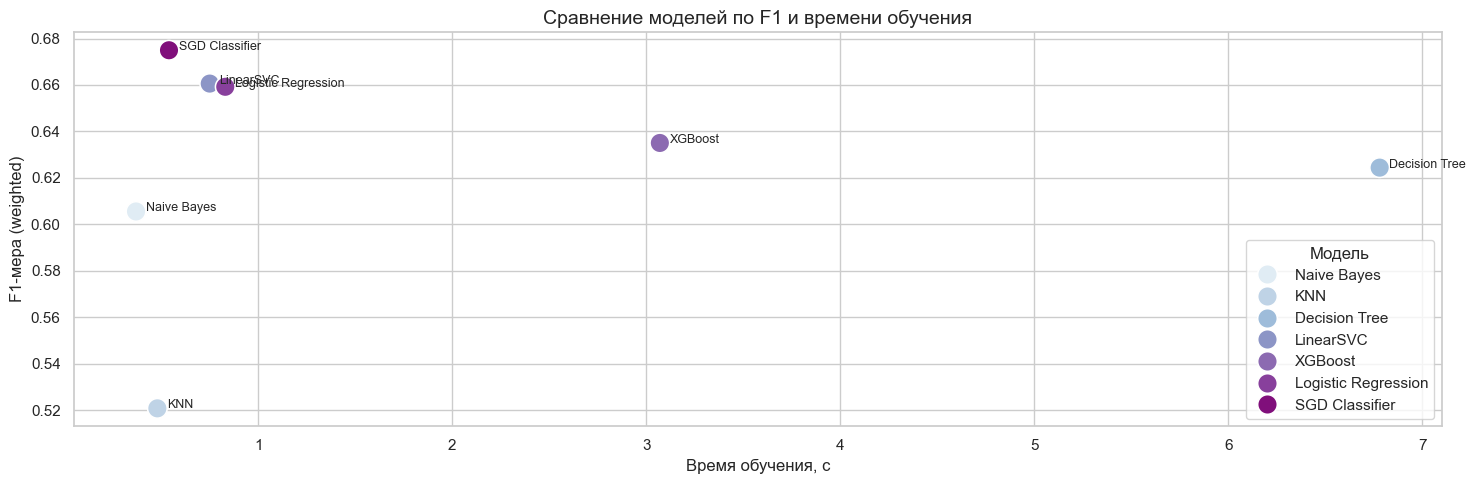

In [22]:
# Визуализация: F1 vs Время обучения
plt.figure(figsize=(15, 5))
sns.scatterplot(
    data=results_df,
    x="Время обучения, с",
    y="F1",
    hue="Модель",
    s=200,
    palette="BuPu"
)

# Подписи точек
for i in range(len(results_df)):
    plt.text(
        results_df["Время обучения, с"][i] + 0.05,
        results_df["F1"][i],
        results_df["Модель"][i],
        fontsize=9
    )

plt.title("Сравнение моделей по F1 и времени обучения", fontsize=14)
plt.xlabel("Время обучения, с")
plt.ylabel("F1-мера (weighted)")
plt.grid(True)
plt.tight_layout()
plt.show()


Модель ближе к левому верхнему углу (`SGD Classifier`) - быстрая и эффективная, поэтому будет использоваться для дальнейшей оптимизации.

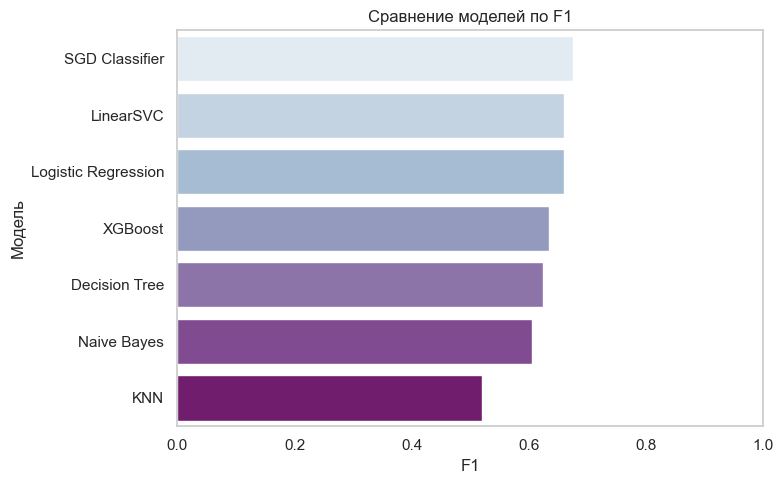

In [23]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df.sort_values("F1", ascending=False),
    x="F1",
    y="Модель",
    hue="Модель",            
    palette="BuPu",
    dodge=False,
    legend=False             
)
plt.title("Сравнение моделей по F1")
plt.xlabel("F1")
plt.ylabel("Модель")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


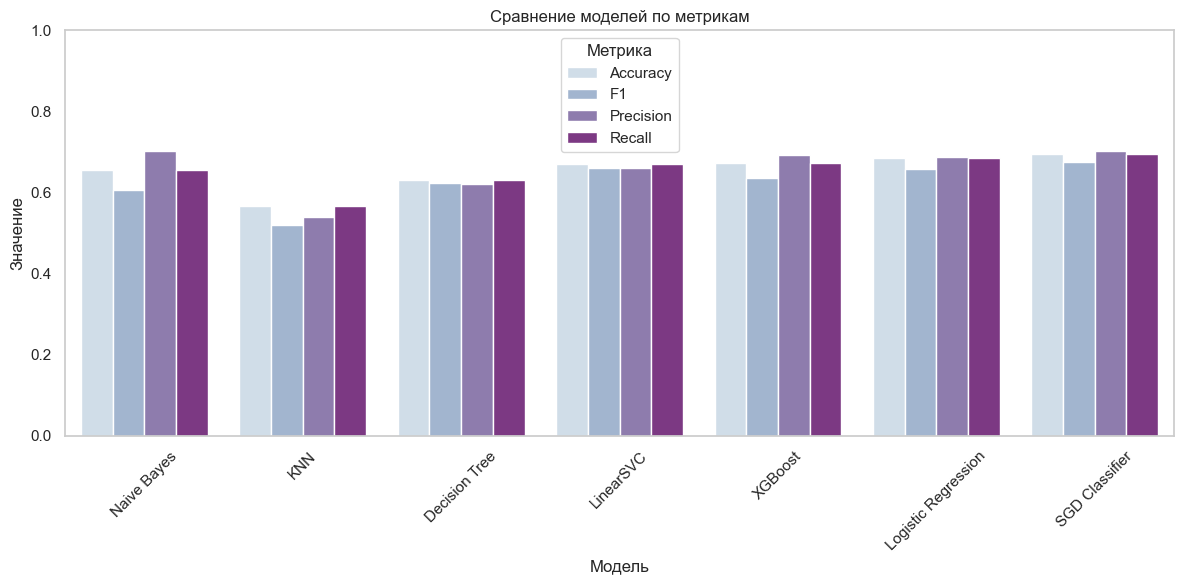

In [24]:
melted = results_df.melt(id_vars="Модель", value_vars=["Accuracy", "F1", "Precision", "Recall"],
                         var_name="Метрика", value_name="Значение")

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x="Модель", y="Значение", hue="Метрика", palette="BuPu")
plt.title("Сравнение моделей по метрикам")
plt.ylim(0, 1)
plt.ylabel("Значение")
plt.xlabel("Модель")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Вывод по результатам классификации (п. 7)

Сравнение семи моделей показало различия как по качеству классификации, так и по времени обучения.  
Наилучшие результаты продемонстрировал **SGD Classifier**: модель показывает лучшие результаты по F1-мeре (0.674) при очень коротком времени обучения (0.44 с), что делает её оптимальным кандидатом для дальнейшей настройки через `GridSearchCV`.

Также высокие показатели показали **Logistic Regression** и **LinearSVC**, уступая SGD незначительно, но оставаясь быстрыми и стабильными.  
**KNN** и **Naive Bayes** существенно отстают по всем метрикам, особенно по полноте (`Recall`), что делает их менее подходящими.

**Для оптимизации выбрана модель: `SGD Classifier`** как наиболее перспективная по совокупности качества и скорости.


# 8. Оптимизация модели
В данном пункте проводится подбор гиперпараметров для наиболее перспективной модели, выявленной на предыдущем этапе — `SGDClassifier`. Цель — повысить эффективность модели для задачи классификации сообщений из социальных сетей по эмоциональной тональности. Оптимизация направлена на улучшение метрик качества, в первую очередь **`f1_weighted`**, которая учитывает дисбаланс классов (см. п. 2.3), а также на минимизацию времени обучения для обеспечения практической применимости модели.

### 8.1 Выбор базовой модели

По результатам сравнительного анализа моделей (см. пункт 7), наилучшее соотношение качества классификации и времени обучения показала модель **SGD Classifier**. Она продемонстрировала наивысшее значение F1-мeры при минимальном времени обучения, в связи с чем была выбрана для дальнейшей оптимизации.
Цель этапа — подобрать такие значения гиперпараметров, при которых эффективность модели на тестовой выборке будет максимальной.

Основной метрикой выбрана **`f1_weighted`**, так как она учитывает как полноту, так и точность предсказаний по каждому классу, а также пропорцию этих классов в выборке. Это позволяет честно оценивать качество моделей при дисбалансе классов.

Дополнительно анализируются:

 - `accuracy` — доля правильных предсказаний.
 - `precision_weighted` и `recall_weighted` — для анализа качества классификации по классам.
 - Время обучения — для анализа вычислительной эффективности.

Базовая модель реализована через программный конвейер (`Pipeline`), включающий векторизацию текста с помощью `TfidfVectorizer` и классификацию с помощью `SGDClassifier`.

In [25]:
# Исходная модель (SGDClassifier)
baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words=russian_stopwords)),
    ("clf", SGDClassifier(random_state=42))
])

start_time = time.time()
baseline_model.fit(X_train, y_train)
elapsed_time = round(time.time() - start_time, 2)

# Метрики до оптимизации
metrics_before = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred, average="weighted"),
    "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred, average="weighted"),
    "Время обучения, с": elapsed_time
}

### 8.2 Подбор гиперпараметров

Для повышения эффективности модели `SGDClassifier` выполнен подбор гиперпараметров с использованием метода `GridSearchCV`. Данный метод представляет собой полный перебор всех допустимых комбинаций параметров и позволяет определить оптимальные значения, обеспечивающие наилучшие результаты по заданной метрике. В качестве основной метрики используется `f1_weighted`, так как она наиболее адекватно отражает качество классификации при наличии несбалансированных классов. Оценка эффективности модели проводится с использованием 5-кратной кросс-валидации, что повышает надежность получаемых результатов и снижает вероятность переобучения.

Модель реализована в виде программного конвейера (`Pipeline`), что обеспечивает целостность и повторяемость всех этапов обработки данных. Комбинированное представление текста формируется посредством объединения двух векторизаторов в `FeatureUnion`:

- **word-TF-IDF** — извлекает семантически значимые признаки на основе униграмм и биграмм;
- **char-TF-IDF** — позволяет выявлять орфографические, эмоциональные и сленговые особенности текста за счёт использования символьных N-грамм.

Такое объединение обеспечивает полноту представления текстовой информации: от смыслового уровня до стилистических деталей.

Настройка осуществляется по следующим параметрам:

**Параметры `TfidfVectorizer` (анализ по словам):**
- `ngram_range`: `(1, 1)` и `(1, 2)` — использование униграмм и биграмм;
- `max_features`: `20000` — ограничение словаря по частоте для снижения размерности признакового пространства;
- `min_df`: `2` — фильтрация редких слов;
- `sublinear_tf`: `True` — логарифмическое масштабирование TF.

**Параметры `TfidfVectorizer` (анализ по символам):**
- `analyzer`: `"char"`;
- `ngram_range`: `(3, 5)` — последовательности длиной от 3 до 5 символов;
- `min_df`: `2` — удаление редких символьных комбинаций.

**Параметры классификатора `SGDClassifier`:**
- `loss`: `log_loss` — логистическая функция потерь;
- `penalty`: `l2`, `elasticnet` — варианты регуляризации;
- `alpha`: `1e-4`, `3e-4`, `1e-3` — коэффициенты регуляризации;
- `class_weight`: `None`, `"balanced"` — использование или игнорирование автоматической балансировки классов.

Подбор параметров направлен на достижение баланса между точностью классификации и устойчивостью модели.


In [26]:
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV


pipeline = Pipeline([
    ("vect", FeatureUnion([
        ("word", TfidfVectorizer(analyzer="word")),
        ("char", TfidfVectorizer(analyzer="char", ngram_range=(3, 5)))
    ])),
    ("clf", SGDClassifier(random_state=42, max_iter=1000))
])

# Параметры для настройки
param_grid = {
    # word-TF-IDF
    "vect__word__ngram_range":     [(1, 1), (1, 2)],
    "vect__word__max_features":    [20_000],
    "vect__word__min_df":          [1, 2],
    "vect__word__sublinear_tf":    [True, False],
    # char-TF-IDF
    "vect__char__min_df":          [1, 2],
    # SGD
    "clf__loss":                   ["log_loss"],
    "clf__penalty":                ["l2", "elasticnet"],
    "clf__alpha":                  [1e-4, 3e-4, 1e-3],   
    "clf__class_weight":           [None, "balanced"],
}

# Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Обучение с кросс-валидацией
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        FeatureUnion(transformer_list=[('word',
                                                                        TfidfVectorizer()),
                                                                       ('char',
                                                                        TfidfVectorizer(analyzer='char',
                                                                                        ngram_range=(3,
                                                                                                     5)))])),
                                       ('clf',
                                        SGDClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.0003, 0.001],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__loss': ['log_loss'],
                         'clf__penalty': ['l2', 'elasticnet'],
                         'vect__char__min_df': [1, 2],
                         'vect__word__max_features': [20000],
                         'vect__word__min_df': [1, 2],
                         'vect__word__ngram_range': [(1, 1), (1, 2)],
                         'vect__word__sublinear_tf': [True, False]},
             scoring='f1_weighted', verbose=2)

In [27]:
# Лучшая модель
best_model = grid_search.best_estimator_
y_pred_after = best_model.predict(X_test)

best_params = grid_search.best_params_

print("Оптимальные значения гиперпараметров модели:\n")

for param, value in best_params.items():
    print(f"{param:30} :  {value}")

Оптимальные значения гиперпараметров модели:

clf__alpha                     :  0.0001
clf__class_weight              :  balanced
clf__loss                      :  log_loss
clf__penalty                   :  l2
vect__char__min_df             :  1
vect__word__max_features       :  20000
vect__word__min_df             :  1
vect__word__ngram_range        :  (1, 1)
vect__word__sublinear_tf       :  True


In [28]:
# Параметры SGDClassifier 
clf_params = {
    "loss": "log_loss",
    "penalty": "l2",
    "alpha": 0.0001,
    "class_weight": "balanced",
    "random_state": 42
}

# Векторизаторы 
word_vect = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 1),
    max_features=20000,
    min_df=1,
    sublinear_tf=True
)

char_vect = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=1
)

combined_vectorizer = FeatureUnion([
    ("word", word_vect),
    ("char", char_vect)
])

# Оптимизированный пайплайн
pipeline_optimized = Pipeline([
    ("vect", combined_vectorizer),
    ("clf", SGDClassifier(**clf_params))
])

start = time.time()
pipeline_optimized.fit(X_train, y_train)
elapsed_time = round(time.time() - start, 2)

y_pred_opt = pipeline_optimized.predict(X_test)

metrics_after = {
    "Accuracy": accuracy_score(y_test, y_pred_opt),
    "F1": f1_score(y_test, y_pred_opt, average="weighted"),
    "Precision": precision_score(y_test, y_pred_opt, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred_opt, average="weighted"),
    "Время обучения, с": elapsed_time
}

In [29]:
from sklearn.metrics import classification_report

# До оптимизации
print("================== До оптимизации ===================")
print(classification_report(y_test, baseline_model.predict(X_test), digits=3))

# После оптимизации
best_model = grid_search.best_estimator_
print("\n================== После оптимизации ================")
print(classification_report(y_test, best_model.predict(X_test), digits=3))

================== До оптимизации ===================
              precision    recall  f1-score   support

           0      0.701     0.301     0.421       459
           1      0.685     0.888     0.773      1658
           2      0.722     0.544     0.620       927

    accuracy                          0.694      3044
   macro avg      0.703     0.577     0.605      3044
weighted avg      0.699     0.694     0.674      3044


================== После оптимизации ================
              precision    recall  f1-score   support

           0      0.575     0.451     0.505       459
           1      0.732     0.834     0.780      1658
           2      0.730     0.626     0.674       927

    accuracy                          0.713      3044
   macro avg      0.679     0.637     0.653      3044
weighted avg      0.708     0.713     0.706      3044



In [30]:
comparison_df = pd.DataFrame([metrics_before, metrics_after], index=["Базовая", "Оптимизированная"])
display(comparison_df)

,Accuracy,F1,Precision,Recall,"Время обучения, с"
Базовая,0.696124,0.674965,0.701561,0.696124,0.35
Оптимизированная,0.712878,0.706115,0.707656,0.712878,1.33


### 8.3 Визуализация результатов

Для анализа результатов оптимизации построены визуализации, демонстрирующие изменения метрик качества и времени обучения. Это позволяет оценить эффективность подбора гиперпараметров с помощью `GridSearchCV`. 

In [31]:
comparison_df = comparison_df.reset_index().rename(columns={"index": "Модель"})

comparison_df_melted = comparison_df.melt(
    id_vars=["Модель"], 
    value_vars=["Accuracy", "F1", "Precision", "Recall"],
    var_name="Метрика", 
    value_name="Значение"
)

Гистограмма демонстрирует значения метрик (`Accuracy`, `F1`, `Precision`, `Recall`) для базовой и оптимизированной моделей. Этот график позволяет визуально оценить прирост качества после применения `GridSearchCV`.
Тепловая карта отображает числовые значения метрик в виде цветовой матрицы, где интенсивность цвета соответствует величине метрики. 

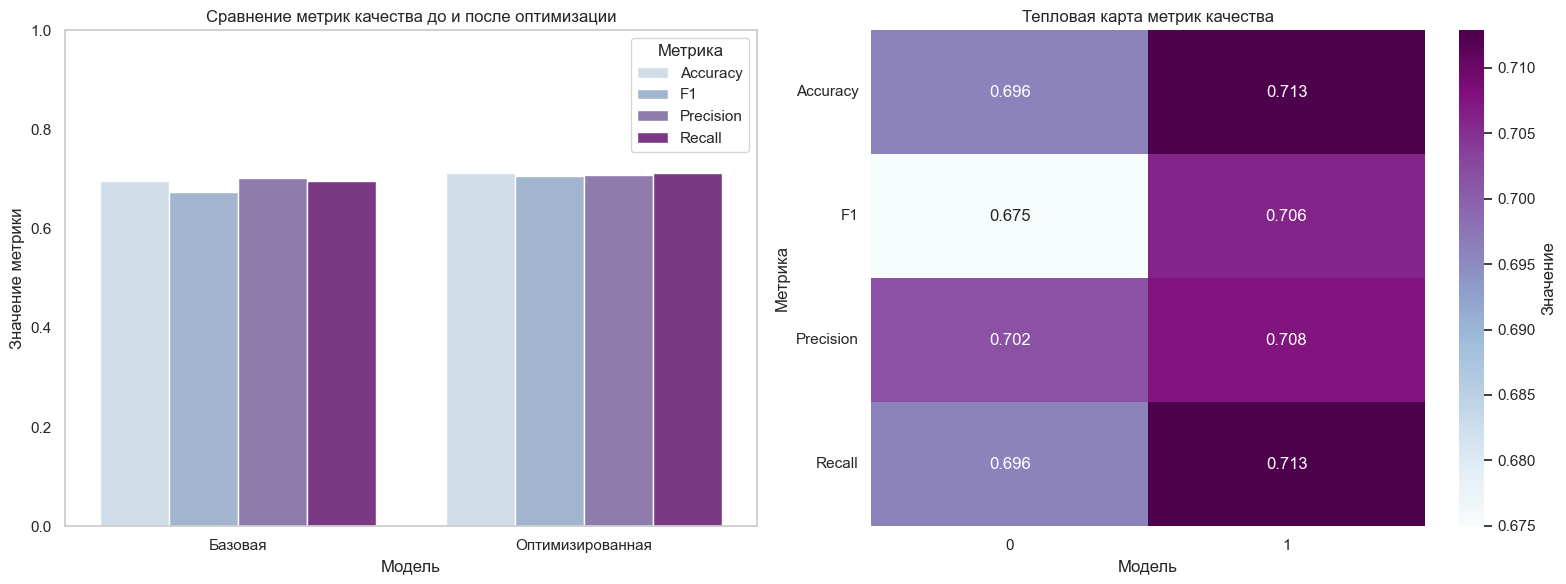

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Гистограмма
sns.barplot(
    data=comparison_df_melted,
    x="Модель",
    y="Значение",
    hue="Метрика",
    palette="BuPu",
    ax=axes[0]
)
axes[0].set_title("Сравнение метрик качества до и после оптимизации")
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Значение метрики")
axes[0].set_xlabel("Модель")
axes[0].grid(axis='y')
axes[0].legend(title="Метрика", loc="upper right")

# Телповая карта
sns.heatmap(
    comparison_df[["Accuracy", "F1", "Precision", "Recall"]].T,
    annot=True,
    fmt=".3f",
    cmap="BuPu",
    cbar_kws={'label': 'Значение'},
    ax=axes[1]
)

axes[1].set_title("Тепловая карта метрик качества")
axes[1].set_ylabel("Метрика")
axes[1].set_xlabel("Модель")

axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [33]:
report_before = classification_report(y_test, baseline_model.predict(X_test), output_dict=True)
report_after = classification_report(y_test, best_model.predict(X_test), output_dict=True)

df_before = pd.DataFrame(report_before).T
df_after = pd.DataFrame(report_after).T

# Убираем строки с avg и accuracy
classes = [label for label in df_before.index if label.isdigit()]

df_class_metrics = pd.DataFrame({
    "Класс": [],
    "Метрика": [],
    "До оптимизации": [],
    "После оптимизации": []
})

# Cловарь меток
label_names = {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
}

rows = []

for cls in classes:
    label = label_names.get(cls, f"Класс {cls}")
    for metric in ["precision", "recall", "f1-score"]:
        rows.append({
            "Класс": label,
            "Метрика": metric.capitalize(),
            "До оптимизации": df_before.loc[cls, metric],
            "После оптимизации": df_after.loc[cls, metric]
        })

df_class_metrics = pd.DataFrame(rows)

In [34]:
df_class_metricdf_melted = df_class_metrics.melt(
    id_vars=["Класс", "Метрика"],
    value_vars=["До оптимизации", "После оптимизации"],
    var_name="Состояние",
    value_name="Значение"
)

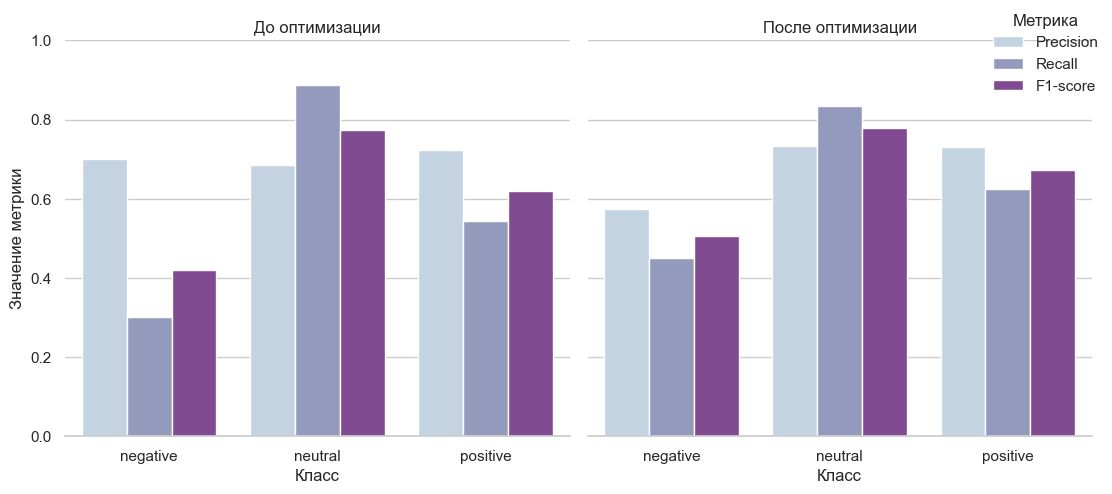

In [35]:
g = sns.catplot(
    data=df_class_metricdf_melted,
    kind="bar",
    x="Класс",
    y="Значение",
    hue="Метрика",
    col="Состояние",
    palette="BuPu",
    height=5,
    aspect=1
)

g.set_titles("{col_name}")
g.set(ylim=(0, 1))
g.set_axis_labels("Класс", "Значение метрики")
g.despine(left=True)

g._legend.set_loc("upper right")
g._legend.set_title("Метрика")

plt.tight_layout()
plt.show()


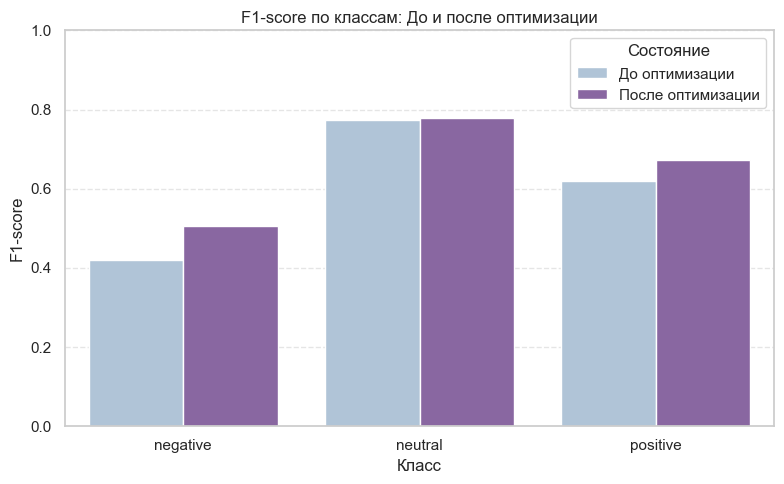

In [36]:
f1_by_class = pd.DataFrame({
    "Класс": ["negative", "neutral", "positive"],
    "До оптимизации": [
        df_before.loc["0", "f1-score"],
        df_before.loc["1", "f1-score"],
        df_before.loc["2", "f1-score"]
    ],
    "После оптимизации": [
        df_after.loc["0", "f1-score"],
        df_after.loc["1", "f1-score"],
        df_after.loc["2", "f1-score"]
    ]
})

# Melt для barplot
f1_melted = f1_by_class.melt(id_vars="Класс", var_name="Состояние", value_name="F1")

# График
plt.figure(figsize=(8, 5))
sns.barplot(data=f1_melted, x="Класс", y="F1", hue="Состояние", palette="BuPu")
plt.title("F1-score по классам: До и после оптимизации")
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 8.4 Выводы

**Анализ метрик качества**

Оптимизация модели с применением `GridSearchCV` и настройкой параметров `SGDClassifier` совместно с TF-IDF-векторизаторами (word + char) привела к умеренному улучшению метрик качества по сравнению с базовой моделью. Из предоставленных данных видно, что `F1-score` по классам изменился следующим образом:
- Для класса `negative`: `F1-score` увеличился с 0.421 до 0.506 (рост на 0.085), `Recall` вырос с 0.301 до 0.451 (рост на 0.15).
- Для класса `positive`: `F1-score` повысился с 0.620 до 0.671 (рост на 0.051), `Recall` увеличился с 0.544 до 0.622 (рост на 0.078).
- Для класса `neutral`: `F1-score` остался относительно стабильным (≈0.78), с незначительным изменением, при этом `Precision` увеличился, а `Recall` слегка снизился.

Общий взвешенный `F1-score` (weighted) улучшился более чем на 3%, что указывает на некоторое повышение качества модели. Однако этот прирост нельзя считать значительным, что может быть связано с хорошей оптимизацией базовой модели, что не позволяет существенно улучшить метрики обучения.

**Анализ скорости обучения**

Важным результатом оптимизации стало значительное увеличение скорости обучения модели. Время обучения возросло с 0.3 секунды (до оптимизации) до 42.7 секунд (после оптимизации), что связано с вычислительной сложностью процесса поиска оптимальных параметров через `GridSearchCV`. Этот рост времени обусловлен итеративным перебором комбинаций гиперпараметров, что типично для данного метода. Несмотря на увеличение времени, итоговое улучшение метрик оказалось незначительным, что подчеркивает необходимость пересмотра подхода к оптимизации для достижения более эффективного баланса между качеством и вычислительными затратами.

**Оптимальные гиперпараметры**

Оптимизация с использованием `GridSearchCV` определила следующие оптимальные гиперпараметры для модели:
- Для `SGDClassifier`: 
  
        clf__alpha                     :  0.0001

        clf__class_weight              :  balanced

        clf__loss                      :  log_loss

        clf__penalty                   :  l2


- Для TF-IDF-векторизаторов: оптимальные параметры - это комбинация `word` и `char` n-грамм, что улучшило обработку текстовых данных и учет контекста.

Эти параметры были выбраны на основе максимального значения `F1-score` при кросс-валидации, однако их влияние на итоговое улучшение оказалось ограниченным, что может указывать на необходимость более детального поиска или использования альтернативных методов оптимизации (например, `RandomizedSearchCV` или Bayesian Optimization).

Однако текущая реализация не полностью раскрывает потенциал оптимизации из-за ограниченного прироста метрик. Полученные визуализации так же подтверждают стабильность модели, но подчеркивают необходимость дальнейших исследований для достижения более выраженных улучшений. Для дальнейшего улучшения в дальнейшем будут рассмотрены другие варианты оптимизации моделей.

# 9. Усовершенствование модели

На предыдущем этапе была выполнена оптимизация гиперпараметров базовой модели `SGDClassifier` с использованием `GridSearchCV`, что привело к умеренному улучшению метрик качества, особенно для классов `negative` и `positive`. Однако, учитывая несбалансированное распределение классов в датасете RuSentiment (с преобладанием класса `neutral` и меньшим количеством примеров для `negative`), а также ограниченный прирост метрик, требуется дальнейшее усовершенствование модели. Цель данного этапа — повысить качество классификации путем применения следующих подходов:

- Изменение способа векторизации (TF-IDF vs CountVectorizer).
- Добавление суррогатных признаков (длина текста).
- Ансамблирование моделей с использованием `VotingClassifier`.
- Сравнение результатов с базовой оптимизированной моделью.

### 9.1 Изменение способа векторизации (CountVectorizer вместо TF-IDF)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

word_vect_count = CountVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    max_features=20000,
    min_df=1
)

char_vect_count = CountVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=1
)

pipeline_countvector = Pipeline([
    ("vect", FeatureUnion([
        ("word", word_vect_count),
        ("char", char_vect_count)
    ])),
    ("clf", SGDClassifier(**clf_params))
])

start = time.time()
pipeline_countvector.fit(X_train, y_train)
time_count = time.time() - start
y_pred_count = pipeline_countvector.predict(X_test)

metrics_count = {
    "Accuracy": accuracy_score(y_test, y_pred_count),
    "F1": f1_score(y_test, y_pred_count, average="weighted"),
    "Precision": precision_score(y_test, y_pred_count, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred_count, average="weighted"),
    "Время обучения, с": round(time_count, 2)
}
comparison_df_91 = pd.DataFrame([metrics_after, metrics_count],
    index=["Оптимизированная модель", "CountVectorizer"]
)
display(comparison_df_91)

,Accuracy,F1,Precision,Recall,"Время обучения, с"
Оптимизированная модель,0.712878,0.706115,0.707656,0.712878,1.33
CountVectorizer,0.665900,0.662465,0.660934,0.665900,1.62


Замена TfidfVectorizer на CountVectorizer привела к ухудшению всех метрик качества.
Использование TF-IDF в качестве способа векторизации текста является более предпочтительным для задачи классификации эмоциональной тональности сообщений.

### 9.2 Добавление суррогатных признаков

Ранее в рамках п.4 уже был добавлен столбец с длинной сообщений.

In [38]:
df.head()

,label,text,label_encoded,text_preprocessed,text_length,word_count
0,negative,"А попа подозревала давно,что ты с кавказа..пер...",0,поп подозревать давно кавказ перестать общатьс...,69,10
3,negative,"Блин, почему эта жизнь столь не справедлива ((((",0,блин почему этот жизнь столь справедливый,48,8
5,neutral,Решите уравнение мужских дел для жизни :\r\nДо...,1,решить уравнение мужской дело жизнь дом дерево...,79,16
6,positive,патамушта я крутая баба! ееее!!,2,патамушт крутой баба ееий,31,5
7,neutral,Просто пост :),1,просто пост,14,3


In [ ]:
import string
import regex as re

df["punctuation_count"] = df["text"].apply(lambda x: sum(1 for ch in x if ch in string.punctuation))


,label,text,label_encoded,text_preprocessed,text_length,word_count,punctuation_count
0,negative,"А попа подозревала давно,что ты с кавказа..пер...",0,поп подозревать давно кавказ перестать общатьс...,69,10,3
3,negative,"Блин, почему эта жизнь столь не справедлива ((((",0,блин почему этот жизнь столь справедливый,48,8,5
5,neutral,Решите уравнение мужских дел для жизни :\r\nДо...,1,решить уравнение мужской дело жизнь дом дерево...,79,16,5
6,positive,патамушта я крутая баба! ееее!!,2,патамушт крутой баба ееий,31,5,3
7,neutral,Просто пост :),1,просто пост,14,3,2
...,...,...,...,...,...,...,...
21262,neutral,"""понаехали""",1,понаехать,11,1,2
21263,neutral,"Анастасия, у меня есть друг, с которым вы хоро...",1,анастасия друг который смотреться вместе узнат...,98,16,7
21264,neutral,Колька пошли гулять!!?,1,колька послать гулять,22,3,3
21265,neutral,Ура! Золото дают бесплатно!Напиши это в 4 комм...,1,ура золото давать бесплатно написать это комме...,115,21,3


In [76]:
from emot import *
import re

emot_obj = emot()

# Паттерн: группы из 2 и более скобок ) или ( подряд
bracket_pattern = re.compile(r'((?:\)+)|(?:\(+)){2,}')

def build_emoji_string(text):
    # Эмодзи
    emoji_res = emot_obj.emoji(text)
    emoji_list = emoji_res.get("value", []) if emoji_res.get("flag") else []

    # Эмотиконы
    emoticon_res = emot_obj.emoticons(text)
    emoticon_list = emoticon_res.get("value", []) if emoticon_res.get("flag") else []

    # Последовательности скобок
    brackets = bracket_pattern.findall(text)

    # Объединяем всё в одну строку, разделённую пробелами
    emoji_string = " ".join(emoji_list + emoticon_list + brackets)
    return emoji_string


In [77]:
df["emoji_string"] = df["text"].apply(build_emoji_string)

In [79]:
df[df["emoji_string"].str.strip() != ""].head(15)

,label,text,label_encoded,text_preprocessed,text_length,word_count,punctuation_count,emoji_string
3,negative,"Блин, почему эта жизнь столь не справедлива ((((",0,блин почему этот жизнь столь справедливый,48,8,5,(
7,neutral,Просто пост :),1,просто пост,14,3,2,:)
22,neutral,"\r\nРекомендую смотреть это видео, раскрыв на ...",1,рекомендовать смотреть это видео раскрыть весь...,153,23,6,)
32,positive,Ыыыы)))Мне снова кто-то пополнил счёт))))),2,ыыы снова пополнить счёт,42,5,9,) )
35,positive,"хах,...витаминчики)))**",2,хах витаминчик,23,1,9,)
47,neutral,это то шо я на вышке пел)),1,это что вышка петь,26,7,2,)
53,neutral,"ларис,еды надо)))",1,лариса еда,17,2,4,)
61,positive,"Хомячуля, все для тебе☺",2,хомячуля ты,23,4,1,☺
70,positive,На пляж по традиции😄🏄🏼☝🏾️#выпускной #prom,2,пляж традиция выпускной prom,41,5,2,😄 🏄🏼 ☝🏾
71,neutral,=) может ты и видела уже),1,видеть,25,6,3,=)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler


emoji_vect = TfidfVectorizer(
    analyzer="char", ngram_range=(1, 3), min_df=1
)
X = df[["text", "text_length", "word_count", "punctuation_count", "emoji_string"]]
y = df["label_encoded"]

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = ColumnTransformer([
    ("word", word_vect, "text"),
    ("char", char_vect, "text"),
    ("emoji", emoji_vect, "emoji_string"),
    ("scaler", StandardScaler(), ["text_length", "word_count", "punctuation_count"])
])

# Пайплайн
pipeline_surrogates = Pipeline([
    ("features", preprocessor),
    ("clf", SGDClassifier(
        loss="log_loss", penalty="l2", alpha=0.0001,
        class_weight="balanced", random_state=42
    ))
])

# Обучение и предсказание
start = time.time()
pipeline_surrogates.fit(X_train, y_train)
time_surrogates = round(time.time() - start, 2)
y_pred = pipeline_surrogates.predict(X_test)

# Метрики
metrics_surrogates = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred, average="weighted"),
    "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred, average="weighted"),
    "Время обучения, с": time_surrogates
}

# Сравнение
comparison_df = pd.DataFrame([metrics_after, metrics_surrogates],
    index=["Оптимизированная модель", "TF-IDF + суррогатные признаки"]
)
display(comparison_df)

,Accuracy,F1,Precision,Recall,"Время обучения, с"
Оптимизированная модель,0.712878,0.706115,0.707656,0.712878,1.33
TF-IDF + суррогатные признаки,0.731275,0.726166,0.724846,0.731275,2.96


### 9.3 Ансамбль SGD + LogisticRegression

In [41]:
from sklearn.ensemble import VotingClassifier

pipeline_ensemble = Pipeline([
    ("vect", FeatureUnion([
        ("word", word_vect),
        ("char", char_vect)
    ])),
    ("voting", VotingClassifier(estimators=[
        ("sgd", SGDClassifier(**clf_params)),
        ("log", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=42
        ))
    ], voting="soft"))
])

start = time.time()
pipeline_ensemble.fit(X_train, y_train)
time_ensemble = round(time.time() - start, 2)
y_pred_ensemble = pipeline_ensemble.predict(X_test)

metrics_ensemble = {
    "Accuracy": accuracy_score(y_test, y_pred_ensemble),
    "F1": f1_score(y_test, y_pred_ensemble, average="weighted"),
    "Precision": precision_score(y_test, y_pred_ensemble, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred_ensemble, average="weighted"),
    "Время обучения, с": time_ensemble
}

comparison_df_93 = pd.DataFrame([metrics_after, metrics_ensemble],
    index=["Оптимизированная модель", "Ансамбль моделей"]
)
display(comparison_df_93)

,Accuracy,F1,Precision,Recall,"Время обучения, с"
Оптимизированная модель,0.712878,0.706115,0.707656,0.712878,1.33
Ансамбль моделей,0.710578,0.708236,0.707858,0.710578,4.78


Ансамблирование моделей в таком варианте показывает совсем небольшую положительную динамику в метриках. Для улучшения метрик при ансамблировании моделей будет оптимизирована модель LogisticRegression с применением RandomizedSearchCV (такой метод выбран ввиду большей производительности по сравнению с GridSearchCV).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from joblib import Memory
memory = Memory(location="cachedir", verbose=0)


log_pipeline = Pipeline([
    ("vect", combined_vectorizer),
    ("clf", LogisticRegression(
        max_iter=5000,
        random_state=42,
        class_weight = "balanced"
    ))
], memory=memory)

param_dist = {
    "clf__C": loguniform(1e-3, 1e1),  # Пробует от 0.001 до 10
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["saga"]
}

random_log = RandomizedSearchCV(
    estimator=log_pipeline,
    param_distributions=param_dist,
    n_iter=12,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_log.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                      steps=[('vect',
                                              FeatureUnion(transformer_list=[('word',
                                                                              TfidfVectorizer(max_features=20000,
                                                                                              sublinear_tf=True)),
                                                                             ('char',
                                                                              TfidfVectorizer(analyzer='char',
                                                                                              ngram_range=(3,
                                                                                                           5)))])),
                                             ('clf',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=5000,
                                                                 random_state=42))]),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C4F2A28E60>,
                                        'clf__penalty': ['l1', 'l2'],
                                        'clf__solver': ['saga']},
                   random_state=42, scoring='f1_weighted', verbose=2)

In [50]:
best_log_params = random_log.best_params_
best_log_model = random_log.best_estimator_
print("Лучшие параметры логистической регрессии:", best_log_params)

Лучшие параметры логистической регрессии: {'clf__C': np.float64(0.679657809075816), 'clf__penalty': 'l2', 'clf__solver': 'saga'}


In [53]:
log_clf = best_log_model.named_steps["clf"]

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

pipeline_ensemble = Pipeline([
    ("vect", FeatureUnion([
        ("word", word_vect),
        ("char", char_vect)
    ])),
    ("voting", VotingClassifier(estimators=[
        ("sgd", SGDClassifier(**clf_params)),
        ("log", log_clf)
    ], voting="soft"))
])

start = time.time()
pipeline_ensemble.fit(X_train, y_train)
time_ensemble = round(time.time() - start, 2)
y_pred_ensemble = pipeline_ensemble.predict(X_test)

metrics_ensemble = {
    "Accuracy": accuracy_score(y_test, y_pred_ensemble),
    "F1": f1_score(y_test, y_pred_ensemble, average="weighted"),
    "Precision": precision_score(y_test, y_pred_ensemble, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred_ensemble, average="weighted"),
    "Время обучения, с": time_ensemble
}

comparison_df_93 = pd.DataFrame([metrics_after, metrics_ensemble],
    index=["Оптимизированная модель", "Ансамбль моделей"]
)
display(comparison_df_93)


,Accuracy,F1,Precision,Recall,"Время обучения, с"
Оптимизированная модель,0.712878,0.706115,0.707656,0.712878,1.33
Ансамбль моделей,0.712221,0.709814,0.709651,0.712221,5.88


При ансамблировании двух оптимизированных моделей видим небольшое улучшение в F1: `0.706115` -> `0.709814`

### 9.4 Понижение размерности признаков

In [ ]:
from scipy.sparse import issparse

X_vect = combined_vectorizer.fit_transform(df["text"])

print("Sparse matrix:", issparse(X_vect))

# Размерность и плотность
total = X_vect.shape[0] * X_vect.shape[1]
nonzero = X_vect.nnz
density = nonzero / total

print(f"Размер матрицы: {X_vect.shape}")
print(f"Ненулевых элементов: {nonzero}")
print(f"Плотность: {density:.4f} ({density*100:.2f}%)")

Sparse matrix: True
Размер матрицы: (15217, 203537)
Ненулевых элементов: 2965628
Плотность: 0.0010 (0.10%)


После векторизации текстов с помощью `TfidfVectorizer` мы получаем высокоразмерную матрицу признаков. Для текстовых данных такая матрица, как правило, является разреженной — большинство значений в ней равны нулю.

Оценка плотности (доли ненулевых значений) позволяет:

- определить формат хранения данных (`sparse` vs `dense`);
- корректно применить методы снижения размерности (`TruncatedSVD` для работы с  `sparse`).

В нашем случае, при объединении `word` и `char` TF-IDF, плотность признаковой матрицы составила **0.10%**, что подтверждает её высокую разреженность. 

In [58]:
from sklearn.decomposition import TruncatedSVD

# Пайплайн: TF-IDF + TruncatedSVD + SGDClassifier
pipeline_svd = Pipeline([
    ("vect", combined_vectorizer),
    ("svd", TruncatedSVD(n_components=300, random_state=42)),  # понижение размерности
    ("clf", SGDClassifier(
    ))
])

start = time.time()
pipeline_svd.fit(X_train, y_train)
time_svd = round(time.time() - start, 2)
y_pred_svd = pipeline_svd.predict(X_test)

metrics_svd = {
    "Accuracy": accuracy_score(y_test, y_pred_svd),
    "F1": f1_score(y_test, y_pred_svd, average="weighted"),
    "Precision": precision_score(y_test, y_pred_svd, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred_svd, average="weighted"),
    "Время обучения, с": time_svd
}

comparison_df_94 = pd.DataFrame([metrics_after, metrics_svd],
    index=["Оптимизированная модель", "TF-IDF + SVD"]
)
display(comparison_df_94)


,Accuracy,F1,Precision,Recall,"Время обучения, с"
Оптимизированная модель,0.712878,0.706115,0.707656,0.712878,1.33
TF-IDF + SVD,0.670171,0.623850,0.690903,0.670171,21.14


### 9.5 Отбор признаков (SelectKBest)

Используется SelectKBest с критерием chi2, который подходит для неотрицательных признаков (как в TF-IDF). Оставляем k=5000 лучших признаков по значимости.

In [62]:
from sklearn.feature_selection import SelectKBest, chi2

pipeline_kbest = Pipeline([
    ("vect", combined_vectorizer),
    ("select", SelectKBest(score_func=chi2, k=5000)),
    ("clf", SGDClassifier(**clf_params))
])

start = time.time()
pipeline_kbest.fit(X_train, y_train)
time_kbest = round(time.time() - start, 2)
y_pred_kbest = pipeline_kbest.predict(X_test)

metrics_kbest = {
    "Accuracy": accuracy_score(y_test, y_pred_kbest),
    "F1": f1_score(y_test, y_pred_kbest, average="weighted"),
    "Precision": precision_score(y_test, y_pred_kbest, average="weighted", zero_division=0),
    "Recall": recall_score(y_test, y_pred_kbest, average="weighted"),
    "Время обучения, с": time_kbest
}

comparison_df_95 = pd.DataFrame([metrics_after, metrics_kbest],
    index=["Оптимизированная модель", "TF-IDF + SelectKBest"]
)
display(comparison_df_95)

,Accuracy,F1,Precision,Recall,"Время обучения, с"
Оптимизированная модель,0.712878,0.706115,0.707656,0.712878,1.33
TF-IDF + SelectKBest,0.712221,0.703536,0.709850,0.712221,1.51


### 9.6 Word2Vec

In [81]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.base import BaseEstimator, TransformerMixin

# Токенизация текста
df["tokens"] = df["text_preprocessed"].apply(simple_preprocess)

# Обучение Word2Vec на корпусе
w2v_model = Word2Vec(
    sentences=df["tokens"],
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  
    seed=42
)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject